In [1]:
import torch 
import numpy as np
import transformers, datasets, accelerate, tensorboard, evaluate
from models import Student
import torch.nn as nn
import torch.optim as optim
from util import *
from loss import LossCalulcator
from pretrained_kd import *
from datasets import Array3D, ClassLabel, Features, load_dataset, Image
from matplotlib import pyplot
from tqdm import tqdm
from transformers import AdamW, ViTFeatureExtractor, ViTModel
from torch.profiler import profile, record_function, ProfilerActivity


In [2]:
# define hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
lr = 0.001
lr_stepsize = 20
batch_size = 500
test_batch_size = 100
temperature=2
alpha=0.7


In [3]:
# Load model directly
from transformers import ViTForImageClassification, ViTFeatureExtractor
# from transformers import EfficientNetImageProcessor, EfficientNetForImageClassification


# import timm

feature_extractor = ViTFeatureExtractor.from_pretrained('nateraw/vit-base-patch16-224-cifar10')
teacher = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10')


# processor = EfficientNetImageProcessor.from_pretrained("google/efficientnet-b4")
# teacher = EfficientNetForImageClassification.from_pretrained("google/efficientnet-b4")

# processor = AutoImageProcessor.from_pretrained("ahsanjavid/convnext-tiny-finetuned-cifar10")
# teacher = AutoModelForImageClassification.from_pretrained("ahsanjavid/convnext-tiny-finetuned-cifar10")

# processor = AutoImageProcessor.from_pretrained("aaraki/vit-base-patch16-224-in21k-finetuned-cifar10")
# teacher = AutoModelForImageClassification.from_pretrained("aaraki/vit-base-patch16-224-in21k-finetuned-cifar10")
# feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

/opt/homebrew/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [4]:
print(sum(p.numel() for p in teacher.parameters()))

85806346


In [37]:
student = Student(3, 32, 10, 0.2)
student.load_state_dict(torch.load('model/cifar10_github/epoch_99.bin'))
print(sum(p.numel() for p in student.parameters()))

# model.eval()

11444


In [38]:
from torchvision.transforms import ToTensor, Normalize, Resize, Compose
import torchvision.transforms as transforms
import torchvision.datasets as datasets

transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = {}

dataset['train'] = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar)
dataset['test'] = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar)
dataset['raw_train'] = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())


# split = dataset['train'].train_test_split(test_size=(5000.0/50000), seed=42)

# dataset['splitted_train'] = split['train']
# dataset['validation'] = split['test']

preprocessed_dataloaders={}
preprocessed_dataloaders['train'] = torch.utils.data.DataLoader(dataset['train'], batch_size=batch_size)
preprocessed_dataloaders['test'] = torch.utils.data.DataLoader(dataset['test'], batch_size=test_batch_size)
preprocessed_dataloaders['raw_train'] = torch.utils.data.DataLoader(dataset['raw_train'], batch_size=batch_size)

# preprocessed_dataloaders['validation'] = torch.utils.data.DataLoader(dataset['validation'], batch_size=test_batch_size)



# dataset = load_dataset("cifar10")
# split = dataset['train'].train_test_split(test_size=(5000.0/50000), seed=42)
# # split2 = dataset['train'].train_test_split(test_size=(5000.0/49000))
# dataset['splitted_train'] = split['train']
# # dataset['extra'] = split2['train']
# dataset['validation'] = split['test']


# def preprocess_images(examples):
#     # get batch of images
#     images = examples['img']
#     examples['img'] = [np.array(image) for image in examples['img']]
#     # convert to list of NumPy arrays of shape (C, H, W)
#     images = [np.array(image, dtype=np.uint8) for image in images]
#     images = [np.moveaxis(image, source=-1, destination=0) for image in images]
#     # preprocess and add pixel_values
#     inputs = feature_extractor(images=images)
#     examples['pixel_values'] = inputs['pixel_values']
#     return examples

# features = Features({
#     'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']),
#     # 'img': Image(decode=True, id=None),
#     # could probably change img to int for faster inference
#     'img': Array3D(dtype="float32", shape=(3,32,32)),
#     'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)), })

# # preprocessed_train = dataset['train'].map(preprocess_images, batched=True, features=features)
# preprocessed_val = dataset['validation'].map(preprocess_images, batched=True, features=features)
# # preprocessed_test = dataset['test'].map(preprocess_images, batched=True, features=features)
# preprocessed_splitted_train = dataset['splitted_train'].map(preprocess_images, batched=True, features=features)

# # set format to PyTorch
# # preprocessed_train.set_format('torch', columns=['img', 'pixel_values', 'label'])
# preprocessed_val.set_format('torch', columns=['img', 'pixel_values', 'label'])
# # preprocessed_test.set_format('torch', columns=['img', 'pixel_values', 'label'])
# preprocessed_splitted_train.set_format('torch', columns=['img', 'pixel_values', 'label'])

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
# preprocessed_dataloaders = {}
# preprocessed_dataloaders['splitted_train'] = torch.utils.data.DataLoader(preprocessed_splitted_train, batch_size=batch_size, shuffle=True)
# preprocessed_dataloaders['validation'] = torch.utils.data.DataLoader(preprocessed_val, batch_size=batch_size)
# preprocessed_dataloaders['test'] = torch.utils.data.DataLoader(preprocessed_test, batch_size=test_batch_size)

In [8]:
# import time
# teacher_input = next(iter(preprocessed_dataloaders['splitted_train']))
# start = time.time()
# with torch.no_grad():
#     teacher_output = teacher(teacher_input['pixel_values'])
# total = time.time() - start
# print(total)
# print(teacher_output)

In [9]:
# teacher_saved = torch.load(os.path.join('inference', 'splitted_train.pt'))[0][1]
# print(teacher)
# teacher_input = preprocessed_dataloaders['splitted_train'].dataset
# # print(teacher(teacher_input))
# # print(teacher_input['label'])

In [10]:
# import time
# student_input = next(iter(preprocessed_dataloaders['test']))  
# start = time.time()
# student_output = student(student_input['img'])
# total = time.time()-start
# print(total)
# print(student_output)

In [7]:
loss_calculator = LossCalulcator(temperature, alpha)
optimizer = optim.Adam(
    student.parameters(),
    lr=lr)
# scheduler = optim.lr_scheduler.StepLR(optimizer = optimizer,
                                    # step_size = lr_stepsize)

In [12]:
# # prepare teacher, only need to run once
# teacher_outputs = []
# with torch.no_grad():
#     for images,labels in (preprocessed_dataloaders['raw_train']):
#         teacher_inputs = feature_extractor(images=images, return_tensors='pt', do_rescale=False)
#         teacher_outputs.append(teacher(**teacher_inputs).logits)

# torch.save(teacher_outputs, os.path.join('inference', 'train.pt'))

In [19]:
train(student = student,
    teacher = teacher,
    dataloader = preprocessed_dataloaders['train'],
    val_dataloader = preprocessed_dataloaders['test'],
    optimizer = optimizer,
    # scheduler = scheduler,
    loss_calculator = loss_calculator,
    epochs = epochs,
    device = device,
    )

  2%|▏         | 1/50 [01:26<1:11:01, 86.98s/it]

Epoch 1 took 86.977149 s and has accuracy 0.535600


  4%|▍         | 2/50 [03:04<1:14:37, 93.29s/it]

Epoch 2 took 184.674867 s and has accuracy 0.536200


  6%|▌         | 3/50 [04:35<1:12:12, 92.17s/it]

Epoch 3 took 275.525401 s and has accuracy 0.529000


  8%|▊         | 4/50 [06:14<1:12:34, 94.67s/it]

Epoch 4 took 374.025113 s and has accuracy 0.532000


 10%|█         | 5/50 [07:47<1:10:40, 94.23s/it]

Epoch 5 took 467.453291 s and has accuracy 0.539700


 20%|██        | 10/50 [15:40<1:01:38, 92.46s/it]

Epoch 10 took 940.242531 s and has accuracy 0.537700


 30%|███       | 15/50 [23:03<51:49, 88.84s/it]  

Epoch 15 took 1383.671238 s and has accuracy 0.536800


 40%|████      | 20/50 [30:39<46:04, 92.16s/it]

Epoch 20 took 1839.682158 s and has accuracy 0.537200


 50%|█████     | 25/50 [38:53<40:17, 96.70s/it]

Epoch 25 took 2333.558946 s and has accuracy 0.543600


 60%|██████    | 30/50 [46:50<31:48, 95.40s/it]

Epoch 30 took 2810.878697 s and has accuracy 0.545600


 70%|███████   | 35/50 [54:28<23:06, 92.46s/it]

Epoch 35 took 3267.973433 s and has accuracy 0.544700


 80%|████████  | 40/50 [1:02:12<15:36, 93.62s/it]

Epoch 40 took 3732.343959 s and has accuracy 0.544600


 90%|█████████ | 45/50 [1:09:53<07:38, 91.66s/it]

Epoch 45 took 4193.384106 s and has accuracy 0.551400


100%|██████████| 50/50 [1:17:37<00:00, 93.14s/it]

Epoch 50 took 4657.015811 s and has accuracy 0.557900
Finished Training in 4657.015811, Best Accuracy: 0.557900 (at 50 epochs)


Student(
  (conv_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=30, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=30, out_features=10, bias=True)
  )
)

In [14]:
# preprocessed_test = dataset['test'].map(preprocess_images, batched=True, features=features)
# preprocessed_test.set_format('torch', columns=['img', 'pixel_values', 'label'])
# preprocessed_dataloaders['test'] = torch.utils.data.DataLoader(preprocessed_test, batch_size=test_batch_size)

In [15]:
loss_fn = torch.nn.CrossEntropyLoss()
evaluate_model(preprocessed_dataloaders['test'], student, loss_fn, device)

(0.013352734184265136, 0.5382)

In [9]:
kd_loss = []
ce_loss = []
accuracy = []
training_time = []
prev_tt = 0
loss_fn = torch.nn.CrossEntropyLoss()

for i in range(1, 11): 
    file = torch.load(os.path.join('model','cifar10_pretrained', 'epoch_{}.pth'.format(i*10)))
    student.load_state_dict(file['state_dict'])
    loss, acc = evaluate_model(preprocessed_dataloaders['test'], student, loss_fn, device)
    kd_loss.append(file['kd loss'])
    ce_loss.append(loss)
    accuracy.append(acc)
    tt = file['training time']
    training_time.append(tt-prev_tt)
    prev_tt = tt
    if (i==5): prev_tt=0 # epoch 60 was trained separately so the training time resetted

print(kd_loss)
print(ce_loss)
print(accuracy)
print(training_time)

[2.9119067192077637, 2.798086404800415, 2.623811721801758, 2.648958683013916, 2.700639009475708, 2.624070644378662, 2.628148317337036, 2.605930805206299, 2.5547943115234375, 2.534236192703247]
[0.01448933001756668, 0.014049785959720612, 0.01381456434726715, 0.013430650234222413, 0.013285023272037505, 0.013172258281707764, 0.013123435413837432, 0.01299552470445633, 0.012972171878814697, 0.01280063589811325]
[0.4945, 0.5033, 0.5156, 0.5321, 0.5321, 0.54, 0.5425, 0.5427, 0.5473, 0.5503]
[866.2980179786682, 877.5031671524048, 878.7790353298187, 868.7440049648285, 858.5296969413757, 861.1826407909393, 824.4850714206696, 890.9664273262024, 844.6121180057526, 849.03386759758]


In [10]:
# print(np.mean(np.array(training_time)))

862.013404750824


In [13]:
def plot(xrange, ydata, title, ylabel):
    y = np.array(ydata) * 100
    x = np.arange(0, xrange, step=10) + 10
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel("epoch iteration")
    plt.ylabel(ylabel)
    plt.show()

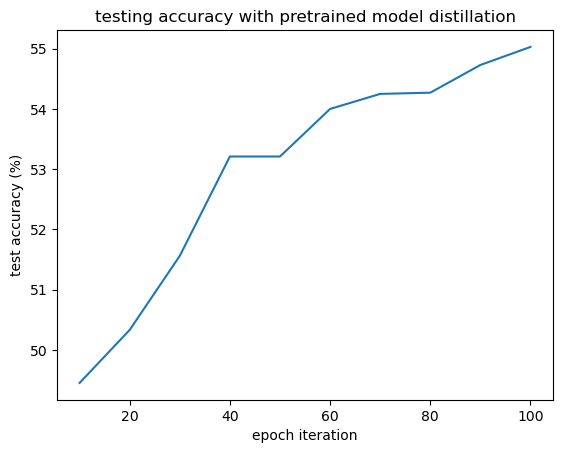

In [14]:
plot(100, accuracy, "testing accuracy with pretrained model distillation", 'test accuracy (%)')

In [12]:
plot(100, ce_loss, "student model cross entropy loss with pretrained model distillation", "cross entropy loss")

NameError: name 'plot' is not defined

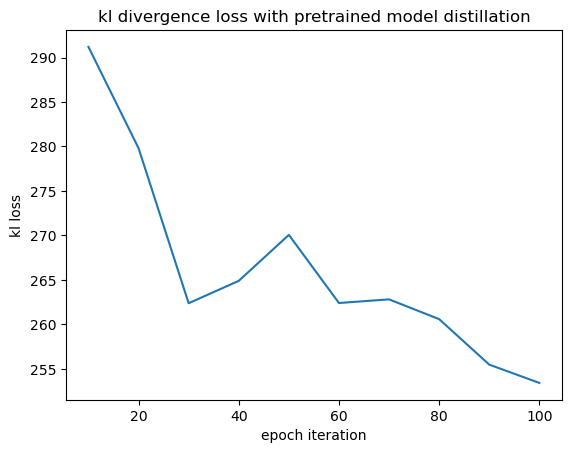

In [38]:
plot(100, kd_loss, "kl divergence loss with pretrained model distillation", "kl loss")

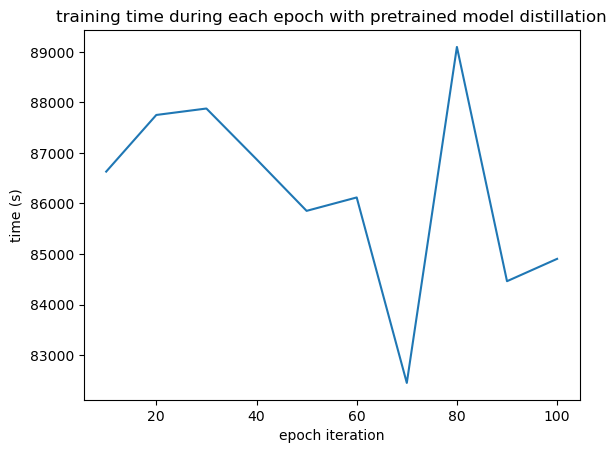

In [47]:
plot(100, training_time, "training time during each epoch with pretrained model distillation", "time (s)")

In [36]:
with profile(activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):
        student(next(iter(preprocessed_dataloaders['test']))[0])

print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))

STAGE:2024-05-15 20:02:15 73279:7421708 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-05-15 20:02:15 73279:7421708 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-15 20:02:15 73279:7421708 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         0.13%     132.000us         0.13%     132.000us       0.430us      50.22 Mb      50.22 Mb           307  
                                          aten::dropout         0.08%      81.000us        38.61%      39.650ms      13.217ms      50.02 Mb           0 b             3  
                                       aten::empty_like         0.10%     105.000us         0.15%     150.000us       1.456us      25.25 Mb     189.00

In [35]:
from models import Teacher

teacher4 = Teacher(3, 32, 4, 10, 0.2)
teacher6 = Teacher(3, 32, 6, 10, 0.2)
teacher8 = Teacher(3, 32, 8, 10, 0.2)

teacher4.load_state_dict(torch.load('model/cifar10_teacher_adamW_github/epoch_99.bin'))
teacher6.load_state_dict(torch.load('model/cifar10_teacher_larger_adamW_github/epoch_99.bin'))
teacher8.load_state_dict(torch.load('model/cifar10_teacher_even_larger_adamW_github/epoch_99.bin'))

with profile(activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):
        teacher4(next(iter(preprocessed_dataloaders['test']))[0])

print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))

STAGE:2024-05-15 20:01:25 73279:7421708 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-05-15 20:01:25 73279:7421708 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-15 20:01:25 73279:7421708 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         0.06%     221.000us         0.06%     221.000us       0.633us     150.19 Mb     150.19 Mb           349  
                                          aten::dropout         0.05%     177.000us        35.43%     138.851ms      23.142ms     125.02 Mb          -8 b             6  
                                       aten::empty_like         0.03%     108.000us         0.06%     223.000us       2.027us     112.68 Mb      12.62

In [30]:
with profile(activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):
        teacher6(next(iter(preprocessed_dataloaders['test']))[0])

print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))

STAGE:2024-05-15 19:53:51 73279:7421708 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         0.13%     470.000us         0.13%     470.000us       1.267us     250.20 Mb     250.20 Mb           371  
                                          aten::dropout         0.05%     192.000us        36.87%     134.038ms      16.755ms     175.02 Mb         -12 b             8  
                                       aten::empty_like         0.05%     166.000us         0.10%     349.000us       3.061us     150.22 Mb     171.00

STAGE:2024-05-15 19:53:52 73279:7421708 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-15 19:53:52 73279:7421708 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [34]:
with profile(activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):
        teacher8(next(iter(preprocessed_dataloaders['test']))[0])

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=15))

STAGE:2024-05-15 19:58:06 73279:7421708 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-05-15 19:58:06 73279:7421708 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-15 19:58:06 73279:7421708 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         2.54%      12.508ms       100.00%     491.827ms     491.827ms           0 b    -551.24 Mb             1  
                                           aten::conv2d         0.01%      61.000us        53.62%     263.727ms      29.303ms     112.50 Mb           0 b             9  
                                      aten::convolution         0.04%     214.000us        53.61%     263.666ms      29.296ms     112.50 Mb           

In [13]:
images = next(iter(preprocessed_dataloaders['raw_train']))[0]
inputs = feature_extractor(images=images, return_tensors='pt', do_rescale=False)
print(inputs['pixel_values'])

tensor([[[[-0.5373, -0.5373, -0.5373,  ...,  0.1608,  0.1608,  0.1608],
          [-0.5373, -0.5373, -0.5373,  ...,  0.1608,  0.1608,  0.1608],
          [-0.5373, -0.5373, -0.5373,  ...,  0.1608,  0.1608,  0.1608],
          ...,
          [ 0.3882,  0.3882,  0.3882,  ..., -0.0353, -0.0353, -0.0353],
          [ 0.3882,  0.3882,  0.3882,  ..., -0.0353, -0.0353, -0.0353],
          [ 0.3882,  0.3882,  0.3882,  ..., -0.0353, -0.0353, -0.0353]],

         [[-0.5137, -0.5137, -0.5137,  ..., -0.0275, -0.0275, -0.0275],
          [-0.5137, -0.5137, -0.5137,  ..., -0.0275, -0.0275, -0.0275],
          [-0.5137, -0.5137, -0.5137,  ..., -0.0275, -0.0275, -0.0275],
          ...,
          [ 0.1294,  0.1294,  0.1294,  ..., -0.2784, -0.2784, -0.2784],
          [ 0.1294,  0.1294,  0.1294,  ..., -0.2784, -0.2784, -0.2784],
          [ 0.1294,  0.1294,  0.1294,  ..., -0.2784, -0.2784, -0.2784]],

         [[-0.5059, -0.5059, -0.5059,  ..., -0.1922, -0.1922, -0.1922],
          [-0.5059, -0.5059, -

In [14]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        teacher(inputs['pixel_values'])

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

STAGE:2024-05-15 16:17:58 70302:7383565 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


: 